# Meta-Labeling for bet side and size

Implementation of Triple-barrier method for determining side and Meta-labeling for size of the bet. Meta-labeling is a technique introduced by Marco Lopez De Prado in Advances to Financial machine learning.

## Imports

In [23]:
%load_ext autoreload
%autoreload 2

# standard imports
from pathlib import PurePath, Path 
import sys
import time
from collections import OrderedDict as od 
import re 
import os 
import json 

# scientific stack
import pandas as pd 
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import math
import mlfinlab as ml
import sklearn as sk
import pyfolio as pf

# visual tools and plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Dataset

We are importing a raw dataset containing tick values sampled as dollar bars.

In [24]:
# read in and store raw tick data in pandas dataframe to be cleaned and transformed
raw_data = pd.read_csv('data/sample_dollar_bars.csv')
raw_data.index = pd.to_datetime(raw_data['date_time'])
raw_data = raw_data.drop('date_time', axis=1)
print(raw_data)

#raw_tick_data['date_time'] = pd.to_datetime(raw_tick_data.date_time)
#raw_tick_data.set_index('date_time', drop=True, inplace=True)

                            open     high      low    close  cum_vol  \
date_time                                                              
2011-07-31 23:31:58.810  1306.00  1308.75  1301.75  1305.75    53658   
2011-08-01 02:55:17.443  1305.75  1309.50  1304.00  1306.50    53552   
2011-08-01 07:25:56.319  1306.75  1309.75  1304.75  1305.00    53543   
2011-08-01 08:33:10.903  1305.00  1305.00  1299.00  1300.00    53830   
2011-08-01 10:51:41.842  1300.00  1307.75  1299.00  1307.75    53734   
...                          ...      ...      ...      ...      ...   
2012-07-30 12:30:28.642  1379.25  1380.00  1377.50  1377.75    50843   
2012-07-30 13:29:21.258  1377.75  1380.00  1377.00  1379.25    50782   
2012-07-30 13:35:05.407  1379.25  1383.25  1379.00  1382.50    50675   
2012-07-30 13:43:43.711  1382.50  1383.25  1380.00  1381.00    50667   
2012-07-30 13:54:26.158  1380.75  1381.75  1379.75  1380.75    50698   

                          cum_dollar  cum_ticks  
date_time    

## Create Dollar Bars

Here we transform the raw ohlc data into various financial data structures that provide a better representation of the movement of trade information throughout the market.  These bars include: dollar, tick, and volume bars.

## Fitting the Primary Model

This is is the primary model that we will use to drive our strategy (EMA Crossover).  This could be any model that makes trading decions based on some criterion.  The purpose is to fina  strategy that can determine good entry/exits points and to use meta-labeling to improve f1 scores.

In [25]:
fast_window = 12
slow_window = 26

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

### Compute side

Here we are computing the side of that the stretegy is leaning to (in this case it will be one moving average over the other).  -1 =  short, +1 = long

In [26]:
raw_tick_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

# lag the signal and remove look ahead bias
raw_data['side'] = raw_data['side'].shift(1)

#drop NaN values from the dataset
raw_tick_data.dropna(axis=0, how='any', inplace=True)
data = raw_data.copy()

data['side'].value_counts()

#print(long_signals)

 1.0    5180
-1.0    4794
Name: side, dtype: int64

In [27]:
# set daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)
print(daily_vol)

date_time
2011-08-01 23:41:59.859         NaN
2011-08-02 06:46:46.576    0.003240
2011-08-02 07:31:03.237    0.003251
2011-08-02 09:07:37.276    0.002876
2011-08-02 10:52:48.191    0.003222
                             ...   
2012-07-30 12:30:28.642    0.008794
2012-07-30 13:29:21.258    0.009193
2012-07-30 13:35:05.407    0.009381
2012-07-30 13:43:43.711    0.009588
2012-07-30 13:54:26.158    0.009764
Name: close, Length: 9945, dtype: float64


In [28]:
# convert from daily vol to hourly vol (since our data in hourly)
trading_hours_in_day = 8
trading_days_in_year = 252

hourly_vol = daily_vol / math.sqrt(trading_hours_in_day * trading_days_in_year)
hourly_vol_mean = hourly_vol.mean()
print(hourly_vol)

date_time
2011-08-01 23:41:59.859         NaN
2011-08-02 06:46:46.576    0.000072
2011-08-02 07:31:03.237    0.000072
2011-08-02 09:07:37.276    0.000064
2011-08-02 10:52:48.191    0.000072
                             ...   
2012-07-30 12:30:28.642    0.000196
2012-07-30 13:29:21.258    0.000205
2012-07-30 13:35:05.407    0.000209
2012-07-30 13:43:43.711    0.000214
2012-07-30 13:54:26.158    0.000217
Name: close, Length: 9945, dtype: float64


### Apply CUSUM Filter

The purpose of the CUSUM filter is to locate instances of change detection.  These are points that will later be used as t_events for the Triple-barrier method.

In [29]:
# apply symetric CUSUM filter and get timestamps for events
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol.mean() * 0.5)
cusum_events

DatetimeIndex(['2011-08-01 08:33:10.903000', '2011-08-01 10:51:41.842000',
               '2011-08-01 13:36:46.215000', '2011-08-01 13:56:56.220000',
               '2011-08-01 14:01:38.747000', '2011-08-01 14:04:31.604000',
               '2011-08-01 14:09:04.277000', '2011-08-01 15:01:17.292000',
               '2011-08-01 15:38:23.090000', '2011-08-01 18:55:39.580000',
               ...
               '2012-07-26 10:24:12.595000', '2012-07-26 11:04:34.072000',
               '2012-07-26 13:33:32.662000', '2012-07-26 14:47:15.969000',
               '2012-07-26 19:36:16.063000', '2012-07-27 12:30:12.984000',
               '2012-07-27 14:54:59.913000', '2012-07-27 17:26:26.802000',
               '2012-07-27 17:39:07.593000', '2012-07-30 06:13:28.136000'],
              dtype='datetime64[ns]', length=1703, freq=None)

In [30]:
# compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)
vertical_barriers

2011-08-01 08:33:10.903   2011-08-02 09:07:37.276
2011-08-01 10:51:41.842   2011-08-02 10:52:48.191
2011-08-01 13:36:46.215   2011-08-02 13:37:28.849
2011-08-01 13:56:56.220   2011-08-02 13:58:04.741
2011-08-01 14:01:38.747   2011-08-02 14:04:29.869
                                    ...          
2012-07-26 19:36:16.063   2012-07-27 19:42:02.421
2012-07-27 12:30:12.984   2012-07-30 06:13:28.136
2012-07-27 14:54:59.913   2012-07-30 06:13:28.136
2012-07-27 17:26:26.802   2012-07-30 06:13:28.136
2012-07-27 17:39:07.593   2012-07-30 06:13:28.136
Name: date_time, Length: 1702, dtype: datetime64[ns]

### Set Take Profit and Stop Loss

In [31]:
pt_sl = [1,2]
min_ret = 0.005

### Get Triple-barrier Events using CUSUM filter

In [32]:
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                #check between hourly and daily vol
                                                target=daily_vol,
                                                min_ret=min_ret,
                                                num_threads=3,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=data['side'],
                                                verbose=True
                                                )

labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

2020-10-14 02:32:34.362917 100.0% apply_pt_sl_on_t1 done after 0.18 minutes. Remaining 0.0 minutes.


-1.0    773
 1.0    734
Name: side, dtype: int64

## Results of the Primary Model

In [33]:
# set variables for analysis
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

In [34]:
# performance metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

#### Classification Report

In [35]:
print('CLassification Report')
print(sk.metrics.classification_report(y_true=actual,  y_pred=pred, zero_division=False))

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       829
           1       0.45      1.00      0.62       678

    accuracy                           0.45      1507
   macro avg       0.22      0.50      0.31      1507
weighted avg       0.20      0.45      0.28      1507



#### Confusion Matrix

In [36]:
print('Confusion Matrix')
sk.metrics.confusion_matrix(actual, pred)

Confusion Matrix


array([[  0, 829],
       [  0, 678]], dtype=int64)

#### Accuracy

In [37]:
print('Accuracy')
sk.metrics.accuracy_score(actual, pred)

Accuracy


0.44990046449900467

## Fit the Meta Model (Train Forest for bet size)

In [38]:
# log returns (this will improve stationality)
raw_data['log_ret'] = np.log(raw_data['close']).diff()

In [39]:
# create momentum columns
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

In [40]:
# create volatility columns
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

In [41]:
# serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

In [42]:
# serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

### Recompute sides

In [43]:
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [44]:
long_signals

date_time
2011-07-31 23:31:58.810    False
2011-08-01 02:55:17.443    False
2011-08-01 07:25:56.319    False
2011-08-01 08:33:10.903    False
2011-08-01 10:51:41.842    False
                           ...  
2012-07-30 12:30:28.642     True
2012-07-30 13:29:21.258    False
2012-07-30 13:35:05.407    False
2012-07-30 13:43:43.711    False
2012-07-30 13:54:26.158    False
Length: 10000, dtype: bool

In [45]:
# remove look ahead bias
raw_data = raw_data.shift(1).dropna()
print(raw_data)

                            open     high      low    close  cum_vol  \
date_time                                                              
2011-08-01 19:53:37.773  1283.25  1285.00  1283.00  1283.50  54519.0   
2011-08-01 19:58:00.210  1283.50  1285.00  1281.50  1282.25  54566.0   
2011-08-01 20:00:00.200  1282.25  1282.75  1279.75  1282.50  54634.0   
2011-08-01 20:10:06.606  1282.50  1283.25  1282.50  1282.50  54669.0   
2011-08-01 23:41:59.859  1282.50  1282.75  1281.00  1282.50  54610.0   
...                          ...      ...      ...      ...      ...   
2012-07-30 12:30:28.642  1377.50  1380.75  1375.75  1379.25  50801.0   
2012-07-30 13:29:21.258  1379.25  1380.00  1377.50  1377.75  50843.0   
2012-07-30 13:35:05.407  1377.75  1380.00  1377.00  1379.25  50782.0   
2012-07-30 13:43:43.711  1379.25  1383.25  1379.00  1382.50  50675.0   
2012-07-30 13:54:26.158  1382.50  1383.25  1380.00  1381.00  50667.0   

                          cum_dollar  cum_ticks    fast_mavg   

In [46]:
# get features at event times
x = raw_data.loc[labels.index, :]
print(x)
#x.head()

                            open     high      low    close  cum_vol  \
2011-08-02 14:55:22.761  1275.00  1276.50  1274.00  1274.75  54942.0   
2011-08-02 16:48:53.474  1269.00  1269.50  1266.00  1267.50  55235.0   
2011-08-02 17:57:51.964  1262.00  1263.75  1260.75  1261.25  55461.0   
2011-08-02 18:20:52.184  1258.25  1261.75  1258.00  1261.50  55559.0   
2011-08-02 19:26:07.927  1263.50  1263.75  1260.25  1260.50  55609.0   
...                          ...      ...      ...      ...      ...   
2012-07-26 19:36:16.063  1353.00  1355.25  1352.25  1353.75  51699.0   
2012-07-27 12:30:12.984  1357.00  1361.75  1356.50  1359.50  51495.0   
2012-07-27 14:54:59.913  1365.25  1366.00  1364.25  1365.75  51282.0   
2012-07-27 17:26:26.802  1372.75  1373.25  1371.75  1372.50  51010.0   
2012-07-27 17:39:07.593  1380.75  1382.00  1379.25  1381.00  50704.0   

                          cum_dollar  cum_ticks    fast_mavg    slow_mavg  \
2011-08-02 14:55:22.761  70063673.75    12075.0  1275.6875

In [47]:
# remove unwanted columns
x.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg'], axis=1, inplace=True)
y = labels['bin']
x.head()

,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-08-02 14:55:22.761,-1.0,-0.000196,-0.000196,0.000785,0.000196,-0.001762,-0.002933,0.001758,0.001897,0.001761,-0.018742,-0.011397,-0.106638,0.183601,0.100157
2011-08-02 16:48:53.474,-1.0,-0.001183,-0.001182,-0.001969,-0.000394,-0.000985,-0.001969,0.001678,0.001680,0.001102,-0.076837,-0.011717,0.009096,0.227381,0.063703
2011-08-02 17:57:51.964,-1.0,-0.000594,-0.000594,-0.003161,-0.003555,-0.002964,-0.000594,0.001744,0.001348,0.001436,0.007057,-0.012208,-0.169049,0.225302,0.154316
2011-08-02 18:20:52.184,-1.0,0.002580,0.002583,0.000198,-0.000396,-0.002964,-0.003358,0.001756,0.001474,0.001719,-0.076219,-0.055336,-0.184983,0.167483,0.087510
2011-08-02 19:26:07.927,-1.0,-0.002377,-0.002374,-0.001189,-0.000397,-0.002769,-0.000793,0.001685,0.001557,0.001952,0.000887,-0.182447,-0.146857,0.115603,0.041220


In [48]:
# print the y values (0, 1)
y.value_counts()

0    829
1    678
Name: bin, dtype: int64

### Model Training

Here we will strart by seperating our dataset in a training and test set for the purpose of implementing our random forest and checking itts abiility to accurately make predictions on the test set.

#### Split into training and test set

In [49]:
raw_data = raw_data.dropna()
#print(raw_data)
x_training_validation = x
print(x_training_validation)
y_training_validation = y
print(y_training_validation)

                         side   log_ret      mom1      mom2      mom3  \
2011-08-02 14:55:22.761  -1.0 -0.000196 -0.000196  0.000785  0.000196   
2011-08-02 16:48:53.474  -1.0 -0.001183 -0.001182 -0.001969 -0.000394   
2011-08-02 17:57:51.964  -1.0 -0.000594 -0.000594 -0.003161 -0.003555   
2011-08-02 18:20:52.184  -1.0  0.002580  0.002583  0.000198 -0.000396   
2011-08-02 19:26:07.927  -1.0 -0.002377 -0.002374 -0.001189 -0.000397   
...                       ...       ...       ...       ...       ...   
2012-07-26 19:36:16.063  -1.0  0.000554  0.000554  0.000554  0.000554   
2012-07-27 12:30:12.984   1.0  0.001841  0.001842  0.003136  0.000736   
2012-07-27 14:54:59.913   1.0  0.000366  0.000366  0.000183 -0.000366   
2012-07-27 17:26:26.802   1.0 -0.000364 -0.000364  0.001277  0.001825   
2012-07-27 17:39:07.593   1.0  0.000181  0.000181  0.001995  0.003451   

                             mom4      mom5  volatility_50  volatility_31  \
2011-08-02 14:55:22.761 -0.001762 -0.002933   

In [50]:
# this creates a seperate training and test set for the RF
x_train, x_validate, y_train, y_validate = sk.model_selection.train_test_split(
                                        x_training_validation, 
                                        y_training_validation,
                                        test_size=0.2,
                                        #train_size=0.30,  
                                        shuffle=False)

In [51]:
y_train

2011-08-02 14:55:22.761    1
2011-08-02 16:48:53.474    1
2011-08-02 17:57:51.964    1
2011-08-02 18:20:52.184    1
2011-08-02 19:26:07.927    1
                          ..
2012-02-06 17:37:45.229    0
2012-02-07 14:51:40.469    1
2012-02-07 15:59:07.847    0
2012-02-10 21:01:32.086    0
2012-02-13 08:19:05.839    0
Name: bin, Length: 1205, dtype: int64

In [52]:
# create train dataframe
train_df = pd.concat([y_train,x_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    653
1    552
Name: bin, dtype: int64

#### Unsample training data for 50/50 split

In [53]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

In [54]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = sk.utils.resample(minority,
                        replace=True,
                        n_samples=majority.shape[0], # to match majority class
                        random_state=42) # figure random state out

train_df = pd.concat([majority, new_minority])
train_df = sk.utils.shuffle(train_df, random_state=42)

,bin,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-09-29 17:35:14.027,1,-1.0,0.001301,0.001302,-0.003671,-0.003240,-0.004960,-0.002594,0.003001,0.002995,0.002546,0.017303,0.076938,-0.011064,0.091981,0.031989
2011-08-09 13:48:02.042,1,1.0,-0.007119,-0.007094,-0.010603,-0.009290,-0.013653,-0.013001,0.007196,0.008648,0.007896,0.182070,0.225754,-0.194305,-0.135978,-0.448187
2011-08-04 15:43:40.842,1,-1.0,0.000613,0.000614,-0.002854,-0.003463,-0.003666,-0.003666,0.002401,0.002177,0.002130,-0.156594,-0.098948,0.034842,-0.085860,0.065597
2011-08-16 07:22:22.328,1,1.0,-0.001251,-0.001250,-0.002290,-0.002705,-0.000834,0.000000,0.002179,0.002078,0.001487,-0.069088,-0.004271,-0.117770,0.275184,-0.024762
2011-09-01 09:13:14.311,1,1.0,0.002051,0.002053,0.002053,0.002877,0.001848,0.003909,0.001804,0.002031,0.002334,0.010239,-0.119923,-0.001011,0.093591,-0.124551


In [55]:
train_df['bin'].value_counts()

1    653
0    653
Name: bin, dtype: int64

#### Create Training Data

In [56]:
y_train = train_df['bin'].dropna()

x_train = train_df.loc[:, train_df.columns != 'bin'].dropna()
print(x_train)

                         side   log_ret      mom1      mom2      mom3  \
2011-09-26 07:52:55.171   1.0  0.001558  0.001560 -0.008602 -0.017057   
2011-11-25 09:49:49.697  -1.0  0.001082  0.001083 -0.002804 -0.009852   
2011-08-16 07:22:22.328   1.0 -0.005020 -0.005007 -0.006251 -0.007286   
2011-08-29 04:08:26.901   1.0  0.000213  0.000213  0.001064  0.001277   
2011-08-09 18:35:51.643  -1.0 -0.000887 -0.000887  0.002892  0.012351   
...                       ...       ...       ...       ...       ...   
2011-12-05 21:00:01.219  -1.0  0.001794  0.001796  0.003197  0.003598   
2011-11-03 14:20:36.509   1.0  0.001418  0.001419  0.003249 -0.000809   
2011-09-12 14:46:04.254   1.0 -0.003505 -0.003499 -0.003499 -0.007838   
2011-08-10 17:44:27.020   1.0  0.003532  0.003538 -0.001320 -0.001540   
2011-08-23 13:58:50.454   1.0  0.000444  0.000444  0.002671  0.000667   

                             mom4      mom5  volatility_50  volatility_31  \
2011-09-26 07:52:55.171 -0.003547 -0.003547   

In [106]:
# fit the model
parameters = {'max_depth': [2, 3, 4, 5, 7, 9],
                'n_estimators': [1, 10, 25, 50, 100, 200],
                'random_state': [42] }


In [107]:
def perform_grid_search(x_data, y_data):
        rf = sk.ensemble.RandomForestClassifier()

        clf = sk.model_selection.GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)

        clf.fit(x_data, y_data)

        print(clf.cv_results_['mean_test_score'])
        print(clf.best_params_['n_estimators'])
        print(clf.best_params_['max_depth'])

        return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

#### Extract Parameters

In [108]:
n_estimator, depth = perform_grid_search(x_train, y_train)
c_random_state = 42
#print('n_estimator: ' + str(n_estimator), '\ndepth: ' + str(depth), '\nc_random_state: ' + str(c_random_state))

[0.52876834 0.59517252 0.62448417 0.61994835 0.62891118 0.62955825
 0.53840354 0.61843742 0.65738731 0.6540862  0.66496388 0.66713006
 0.54675278 0.64606291 0.68307543 0.6880761  0.69644048 0.70338845
 0.57203402 0.68188866 0.71017887 0.72204145 0.73641813 0.74392252
 0.60882749 0.74496433 0.77735864 0.79117133 0.79899346 0.80675415
 0.63973697 0.79180199 0.82901252 0.83658025 0.84095542 0.8411171 ]
200
9


#### Refit new model with best params

In [109]:
rf = sk.ensemble.RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, random_state=c_random_state)
rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=42)

### Training Metrics

In [110]:
y_pred_rf = rf.predict_proba(x_train)[:, 1]
y_pred = rf.predict(x_train)
fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_train, y_pred_rf)

print('Classification Report')
print(sk.metrics.classification_report(y_train, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       653
           1       0.97      0.99      0.98       653

    accuracy                           0.98      1306
   macro avg       0.98      0.98      0.98      1306
weighted avg       0.98      0.98      0.98      1306



In [111]:
print('Confusion Matrix')
print(sk.metrics.confusion_matrix(y_train, y_pred))

Confusion Matrix
[[635  18]
 [  8 645]]


In [112]:
print('Accuracy')
print(sk.metrics.accuracy_score(y_train, y_pred))

Accuracy
0.9800918836140888


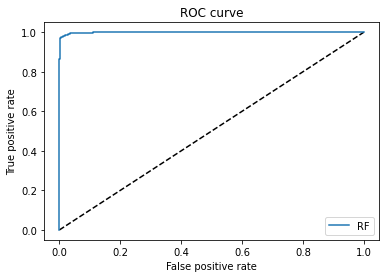

In [113]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [114]:
print('Timestamp of min value :' + ' ' + str(x_validate.index.min()), '\nTimestamp of max value :' + ' ' + str(x_validate.index.max()))

Timestamp of min value : 2012-02-13 15:49:30.707000 
Timestamp of max value : 2012-07-27 17:39:07.593000


### Meta-label 

These are the results of the model with meta-labeling for size

#### Performance Metrics

In [115]:
y_pred_rf = rf.predict_proba(x_validate)[:, 1]
y_pred = rf.predict(x_validate)

fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_validate, y_pred_rf)

print(sk.metrics.classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.95      0.72       176
           1       0.11      0.01      0.01       126

    accuracy                           0.56       302
   macro avg       0.34      0.48      0.37       302
weighted avg       0.38      0.56      0.42       302



#### Confusion Matrix

In [116]:
print(sk.metrics.confusion_matrix(y_validate, y_pred))

[[168   8]
 [125   1]]


#### Accuracy

In [117]:
print(sk.metrics.accuracy_score(y_validate, y_pred))

0.5596026490066225


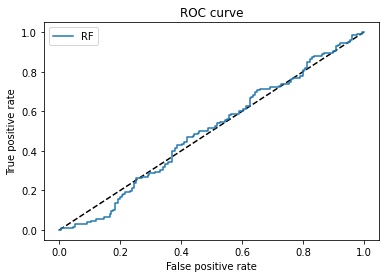

In [118]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [119]:
print('x_validate_min :' + ' ' + str(x_validate.index.min()), '\nx_validate_max :' + ' ' + str(x_validate.index.max()))

x_validate_min : 2012-02-13 15:49:30.707000 
x_validate_max : 2012-07-27 17:39:07.593000


In [120]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']
print(labels)

                              ret      trgt  bin  side
2011-08-02 14:55:22.761  0.011127  0.008710    1  -1.0
2011-08-02 16:48:53.474  0.008583  0.007736    1  -1.0
2011-08-02 17:57:51.964  0.007204  0.006581    1  -1.0
2011-08-02 18:20:52.184  0.008175  0.006286    1  -1.0
2011-08-02 19:26:07.927  0.006200  0.006096    1  -1.0
...                           ...       ...  ...   ...
2012-07-26 19:36:16.063 -0.016144  0.008014    0  -1.0
2012-07-27 12:30:12.984  0.009166  0.007483    1   1.0
2012-07-27 14:54:59.913  0.006767  0.006340    1   1.0
2012-07-27 17:26:26.802  0.006176  0.005829    1   1.0
2012-07-27 17:39:07.593 -0.003074  0.006275    0   1.0

[1507 rows x 4 columns]


Set the time period for primary forecast

In [121]:

start = primary_forecast.index.get_loc('2011-08-02 14:55:22.761')
end = primary_forecast.index.get_loc('2012-07-27 17:39:07.593') + 1

In [122]:
subset_prim = primary_forecast[start:end]

### Performance Metrics

In [123]:
actual = subset_prim['actual']
pred = subset_prim['pred']
print(sk.metrics.classification_report(y_true=actual, y_pred=pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       829
           1       0.45      1.00      0.62       678

    accuracy                           0.45      1507
   macro avg       0.22      0.50      0.31      1507
weighted avg       0.20      0.45      0.28      1507



#### Confusion Matrix

In [124]:
print(sk.metrics.confusion_matrix(actual, pred))

[[  0 829]
 [  0 678]]


#### Accuracy

In [125]:
print(sk.metrics.accuracy_score(actual, pred))

0.44990046449900467


## Feature Importance

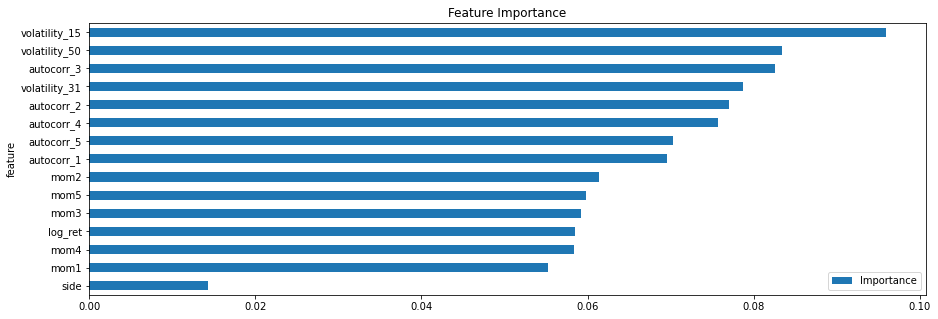

In [126]:
title = 'Feature Importance'
figsize = (15,5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = x.columns
feat_imp.sort_values(by="Importance", ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)

### Perfromance Sheet

In [127]:
def get_daily_returns(intraday_returns):
        """
        Daily returns for pyfolio
        """
        cum_rets = ((intraday_returns + 1).cumprod())
        # Downsample to daily
        daily_rets = cum_rets.resample('B').last()
        # Forward fill, Percent change, Drop NaN
        daily_rets = daily_rets.ffill().pct_change().dropna()
        return daily_rets

In [128]:
valid_dates = x_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [129]:
# Set up the function to extract the KPI's from pyfolio
perf_func = pf.timeseries.perf_stats

In [130]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                        factor_returns=None, 
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])
pf.show_perf_stats(primary_model_rets)

Start date,2012-02-14
End date,2012-07-27
Total months,5
,Backtest
Annual return,25.0%
Cumulative returns,11.1%
Annual volatility,30.4%
Sharpe ratio,0.89
Calmar ratio,1.35
Stability,0.51
Max drawdown,-18.5%


### With Meta-labeling

In [131]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# Save KPIs in a dataframe
erf_stats_all = perf_func(returns=daily_meta_rets, 
                        factor_returns=None, 
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2012-02-14
End date,2012-07-27
Total months,5
,Backtest
Annual return,-13.1%
Cumulative returns,-6.4%
Annual volatility,5.7%
Sharpe ratio,-2.44
Calmar ratio,-2.04
Stability,0.66
Max drawdown,-6.4%


### Out of Sample Test

#### Meta Model Metrics

In [132]:
# extract out of sample data
# oos: out of sample
x_oos = x
y_oos = y

# Performance Metrics
y_pred_rf = rf.predict_proba(x_oos)[:, 1]
y_pred = rf.predict(x_oos)
fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_oos, y_pred_rf)
print(sk.metrics.classification_report(y_oos, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       829
           1       0.95      0.67      0.78       678

    accuracy                           0.83      1507
   macro avg       0.86      0.82      0.82      1507
weighted avg       0.86      0.83      0.83      1507



#### Confusion Matrix

In [133]:
print(sk.metrics.confusion_matrix(y_oos, y_pred))

[[803  26]
 [225 453]]


#### Accuracy

This is the accuracy of the model in addition to the trained meta-labeling model.

In [134]:
print(sk.metrics.accuracy_score(y_oos, y_pred))

0.8334439283344393


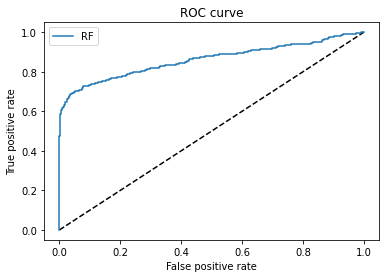

In [135]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Conclusion